# Projekt: YouTube trending videos

### Wstęp

Celem projektu jest przeprowadzenie procesu **odkrywania wiedzy** z danych dotyczących **filmów z serwisu YouTube**.
Należy wskazać, jakie atrybuty powinien mieć przysłany film, aby trafił na **kartę `"na czasie"`**.

### Etap 3 - Ocena ważności atrybutów i ich ewentualna redukcja

### Odrzucenie atrybutów, które zostały wygenerowane automatycznie, a nie wnoszą użytecznych informacji

Część atrybutów została odrzucona już we wcześniejszych etapach.  
Są to atrybuty, które zostały wygenerowane automatycznie, a nie wnoszą użytecznych informacji.  
Przykładem jest np.:
* badanie **wielkości liter** dla kolumny *publish_time*
* **liczba wyrazów** dla *ratings_disabled*



### 1. Znalezienie korelacji między atrybutam 

Do wykonania tego kroku, trzeba zmodyfikować dane wejściowe, dodając kolumny z wyliczonymi atrybutami.  
Do tej pory, były one jedynie sumowane i zapisywane w pliku `json`. 

Liczba atrybutów przed ich redukcją jest na tyle duża, że próba ich wyliczenia i zapisu dla całego zbioru danych, mogłaby się nie udać w związku z długim czasem przetwarzania. Byłoby to szczególnie problematyczne dla atrybutów graficznych. 
W związku z tym, zostanie wybrana reprezentatywna próbka zbioru (po **1000 rekordów**). Dalsze kroki, mające na celu redukcję atrybutów będą wykonywane właśnie na tej próbce. 

Atrybuty nieuwzględnione:  
* Common words_category_id, Contain digits_category_id itd. - ze względu na dużą liczbę braków
* Common words_channel_title	Common words_description	Common words_tags	Common words_title
* Objects_thumbnail_link 
* Main colors_thumbnail_link
* Has text_thumbnail_link

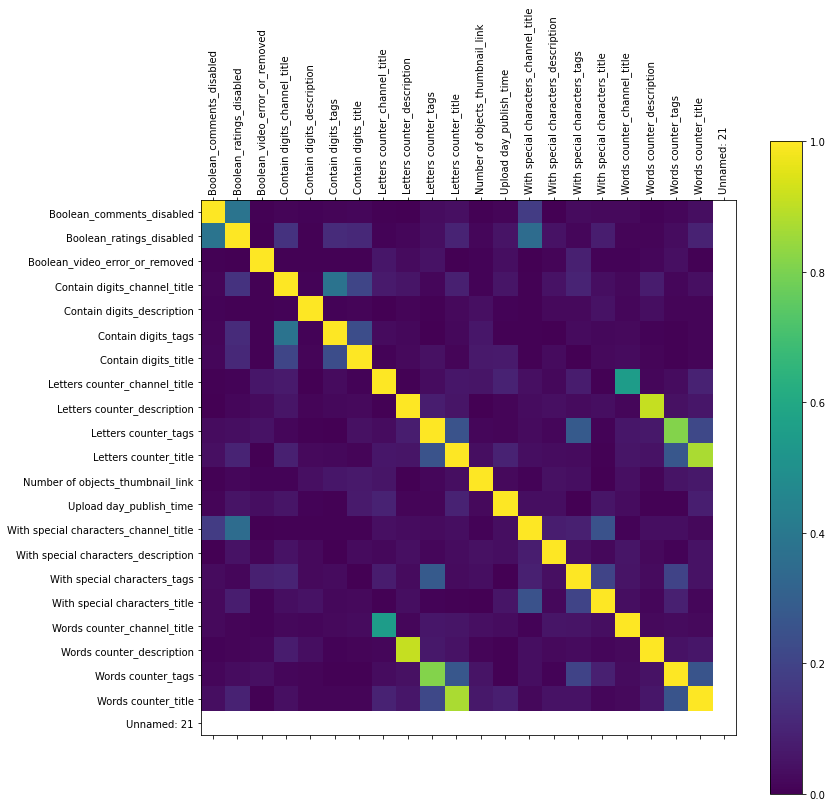

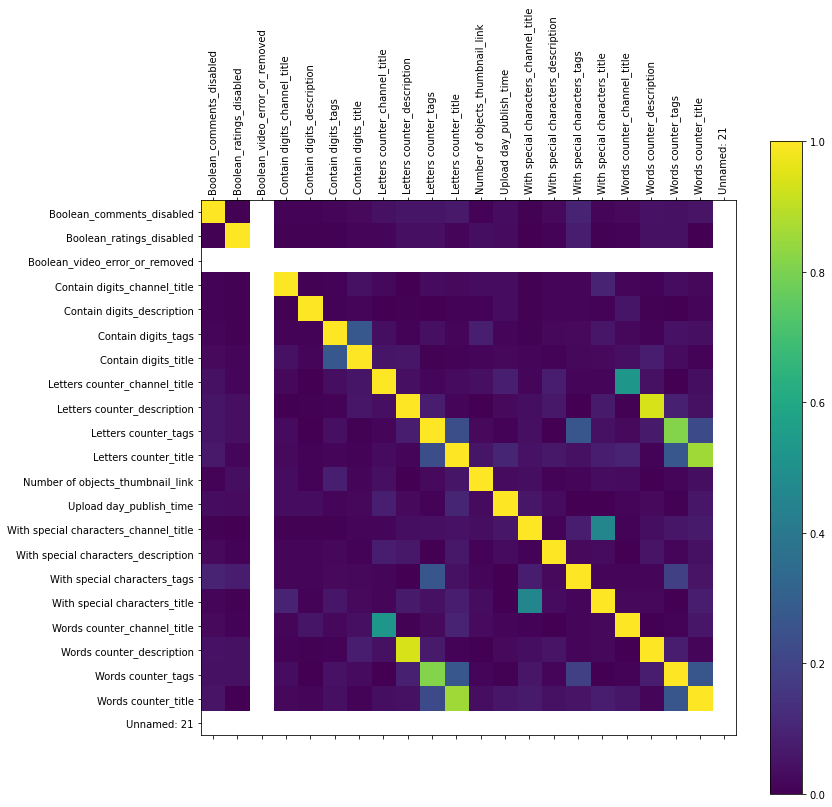

In [14]:
import glob
import os
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy

def get_correlation(filename):
    d = pd.read_csv(filename, sep=';')
    names = list(d.columns) 
    corr = d.corr().abs()
    corr.style.background_gradient(cmap='coolwarm')
    return corr, names

files = ['summary_GB_videos_5p.csv', 'summary_US_videos_5p.csv']

for _file in files:
    correlations, names = get_correlation(_file)
    
    # print matrix
#     print(correlations)
    
    # plot correlation matrix
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations, vmin=0, vmax=1)
    fig.colorbar(cax)
    ticks = numpy.arange(0,len(names),1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(names, rotation='vertical')
    ax.set_yticklabels(names)
    plt.show()

Pary atrybutów z najwyższą korelacją:

In [15]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

get_top_abs_correlations(correlations, 15)

Letters counter_description            Words counter_description        0.996445
Letters counter_title                  Words counter_title              0.983084
Letters counter_tags                   Words counter_tags               0.971013
Letters counter_channel_title          Words counter_channel_title      0.787337
With special characters_channel_title  With special characters_title    0.705705
Contain digits_tags                    Contain digits_title             0.434369
Letters counter_tags                   With special characters_tags     0.371703
Letters counter_title                  Words counter_tags               0.370193
Words counter_tags                     Words counter_title              0.368478
Letters counter_tags                   Letters counter_title            0.323643
                                       Words counter_title              0.317780
With special characters_tags           Words counter_tags               0.292752
Letters counter_channel_titl

Można zauważyć, że najbardziej powiązane są pary atrybutów **liczba znaków** - **liczba wyrazów** dla tych samych kolumn.  
Zatem jeden z tych atrybutów został dodany niepotrzebnie.

Ciekawe jest powiązanie **special characters_channel_title** - **special characters_title**.
Może to oznaczać, że wykrywanie atrybutów zawierających informacje o znakach specjalnych zostały błędnie zaimplementowane.
Prawdopodobnie, są to zawsze znaki, które przedstawiają **egzotyczny alfabet** - nazwa kanału jest zapisana w tym samym języku, co tytuł filmu.

Być może warto dodać wykrywanie języków tekstu oraz poprawić wykrywanie znaków specjalnych, aby znajdowane były jedynie emotikony.

### 2. Znalezienie entropii

Warto zostawić jedynie takie atrybuty, dla których entropia jest bliska 0, ponieważ będzie to oznaczało, że można określić, jakich wartości używać, aby film trafił na kartę "na czasie".

In [16]:
import numpy as np
from scipy.stats import entropy

def _entropy(df, base=None):
    e_list = []
    
    for column in df:
        try:
            labels = df[column]
            value,counts = np.unique(labels, return_counts=True)
            e_list.append([column, entropy(counts, base=base)])
        except Exception as e:
            print(str(e))
            pass
    return sorted(e_list, key=lambda tup: tup[1])

for _file in files:
    df = pd.read_csv(_file, sep=';')
    e = _entropy(df)
    print(f'\n{_file}')
    print(*e, sep='\n')
    print('\n')



summary_GB_videos_5p.csv
['Boolean_video_error_or_removed', 0.014603436691339981]
['With special characters_channel_title', 0.014603436691339981]
['Boolean_ratings_disabled', 0.02639079451281286]
['Contain digits_description', 0.04714115214067802]
['Contain digits_channel_title', 0.061249273239873725]
['Boolean_comments_disabled', 0.07877222303325442]
['Contain digits_tags', 0.07877222303325442]
['Contain digits_title', 0.08709952319177525]
['With special characters_title', 0.13971321718058982]
['Words counter_channel_title', 0.17294011604638437]
['With special characters_tags', 0.2180565982150504]
['With special characters_description', 0.24026567158620693]
['Letters counter_channel_title', 0.950048200589313]
['Words counter_title', 1.124789774655347]
['Number of objects_thumbnail_link', 1.393355085165303]
['Upload day_publish_time', 1.867361577375744]
['Letters counter_title', 2.0745638594373186]
['Words counter_tags', 2.2032848065402737]
['Words counter_description', 3.867192725260

Korzystając z entropii można stwierdzić, że bardzo opłaca się korzystać z atrybutów typu **bool**.
Pozwala to jednoznacznie stwierdzić, czego nie powinno się robić umieszczając film, a co jest wręcz konieczne.



### 3. Atrybuty nieuwzględnione

* **TextAnalyzer** - wykryty tekst nie nadaje się do analizy. Być może jest to wina zastosowanej biblioteki, lub słabej jakości obrazów. Atrybuty z tej kolumny zostaną pominięte.

* **ObjectsNamesAnalyzer** - często rozpoznawany jest **człowiek** (727/1000 oraz 721/100). Pozwala to na dostarczenie cennych informacji.

* **ColorsAnalyzer** - ten **analyzer** również wymaga wprowadzenia poprawek (w końcowym etapie). Na tę chwilę wiadomo, że obraz powinien zawierać głównie różne odcienie szarości. Jest to cenna informacja, ale wymaga dalszej analizy.

## Podsumowanie

#### Atrybuty odrzucone:

* **Zliczanie liczby wyrazów** (dla każdej z kolumn) - ze względu na wysoką wartość korelacji z liczbą liter.
* **Zliczanie liczby liter** (dla wszystkich kolumn, poza **tytułem**) - ze względu na wysoką wartość entropii. Liczba liter **tagów** oraz **opisów** jest bardzo zróżnicowana, co może świadczyć, o nieistotności tego atrybutu.
* **Znaki specjalne** - wykrywanie znaków specjalnych w obecnej formie nie ma sensu. Wysoka korelacja tego atrybutu pomiędzy różnymi kolumnami może wskazywać na to, że znaki specjalne wskazują jedynie na wykorzystanie języków, które nie korzystają z alfabetu łacińskiego. Można jedynie zaznaczyć (klientowi), że zaleca się ich nie używać.
* **Tekst na miniaturach** - wyjaśnienie wyżej (do rozwinięcia w końcowym sprawozdaniu)
* **Analiza kolorów na miniaturach** - podanie klientowi bardziej w formie ciekawostki - nie należy przykładać do niego wielkiej wagi (również do rozwinięcia w końcowym sprawozdaniu)
* **Czas przesłania filmu** - W tym przypadku również występuje duża rozpiętość wartości. Być może także warto odrzucić, lub podać klientowi w formie "zalecenia" (wskazówki), którego nie trzeba przestrzegać za wszelką cenę.